# NSCI 801 - Quantitative Neuroscience
## Data Neuroscience Overview
Gunnar Blohm

### Outline
* Promises and limitations of Data Neuroscience
* Data Organization
    * formats
    * data bases
* intro to ML
    * dimensionality reduction
    * classification
    * decoding

### Promises and limitations of Data Neuroscience
"[...] data are profoundly dumb. Data can tell you that the people who took a medicine recovered faster than people who did not take it, but they can't tell you why." (Pearl, in "the book of why")

**Data alone does not give you the answer!** But data is important when you have the right question and hypothesis (= model)...

<img style="float: center; width:800px;" src="stuff/Pearl-flow.png">

### So what can data neuroscience do for us?
Here are some examples...
* look for structure in really complicated data (= pattern recognition)
* automatically extract information from the data (= data mining)
* simplify data with lots of redundancy (= dimensionality reduction)
* more data = possibility to apply larger statistical models (= curve fitting)
    * e.g. high-dimensional correlations (= decoding)
    * e.g. find differences in data (= classification)

### Data organization
In order to take advantage of big data in neuroscience, we need to organize our data well!
* is it scalable, flexible, future-proof?
* does it integrate with other data (e.g. repositories)?
* is it documented enough to be re-usable?

[Data management made simple](https://www.nature.com/articles/d41586-018-03071-1#:~:text=A%20data%2Dmanagement%20plan%20explains,%2C%20models%2C%20algorithms%20and%20software.)

[The FAIR Guiding Principles for scientific data management and stewardship](https://www.nature.com/articles/sdata201618): Findability, Accessibility, Interoperability, and Reusability

Also check out the NSCI800 lectures on Open Science: [Lecture 1](http://www.compneurosci.com/NSCI800/OpenScienceI.pdf) and [Lecture 2](http://www.compneurosci.com/NSCI800/OpenScienceII.pdf)

### Intro to ML
Machine learning vs. statistics: how are they complementary?

"Statistics is the study of making strong inferences on few variables from small amounts of noisy data. Machine learning is the study of discovering structured relationships between lots of variables with large amounts of data" (Jordan)

* statistics is typically concerned with inferences about parameters of given functional relationships
    * inferences about variables, while taking uncertainty into account
    * requires explicit knowledge about the data sampling process
* machine learning is concerned with inferences about the functional relationships per se
    * inference about higher-order interactions, functions, or mappings among variables
    * makes only weak qualitative assumptions about the data generation process
    
In this way, one might argue that machine learning is qualitatively similar to human intuition, which likewise enables researchers to make reasonable hypotheses regarding functional relationships among variables, albeit simple ones.

### Intro to ML
ML is wide field and we can only have a brief glimpse here... but check out further readings if you want to learn more!

**Good news! You already know how to perform regressions using ML!**

So here we will cover the following:
* classification & regularization
* dimensionality reduction
* decoding

### Classification and regularization
(adapted from [NMA W1D4 tutorial 2](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D4_MachineLearning/student/W1D4_Tutorial2.ipynb))

There are many ways to do classification:
* neural network
* Bayesian classifier
* logistic regression (special case of GLM)
* ...

Here we'll use logistic regression.

### Logistic regression
Logistic Regression is a binary classification model. It is a GLM with a logistic link function and a Bernoulli (i.e. coinflip) noise model.

$$\color{grey}{\hat{y} = \sigma(\theta^Tx)}$$
$$\color{grey}{\sigma(z) = \frac{1}{1+exp(-z)}}$$

with parameter set $\theta$

**Goal**: find paramter set $\theta$ that best maps $x$ onto $y$. We'll use the popular ML library [scikit-learn](https://scikit-learn.org/stable/).

Note: we need a training set for that...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import ipywidgets as widgets

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('dark_background')

In [2]:
#@title Helper functions

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".5")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".5")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")

In [3]:
#@title Data retrieval and loading
import os
import requests
import hashlib

url = "https://osf.io/r9gh8/download"
fname = "W1D4_steinmetz_data.npz"
expected_md5 = "d19716354fed0981267456b80db07ea8"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_steinmetz_data(data_fname=fname):

  with np.load(data_fname) as dobj:
    data = dict(**dobj)

  return data

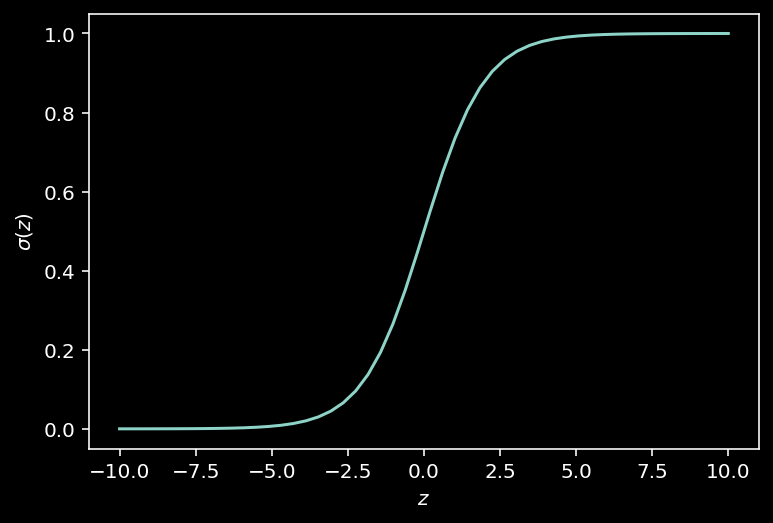

In [4]:
def sigmoid(z):
  """Return the logistic transform of z."""
  return 1 / (1 + np.exp(-z))

plot_function(sigmoid, "\sigma", "z", (-10, 10))

### Data: neural recordings during decision making
[Steinmetz et al. (2019)](https://www.nature.com/articles/s41586-019-1787-x) dataset. We will decode the mouse's decision from the neural data using Logistic Regression. 

So let's load the data and have a look...

In [5]:
data = load_steinmetz_data()
for key, val in data.items():
  print(key, val.shape)

spikes (276, 691)
choices (276,)


* `spikes`: an array of normalized spike rates with shape `(n_trials, n_neurons)`
* `choices`: a vector of 0s and 1s, indicating the animal's behavioral response, with length `n_trials`

So let's define our inputs and outputs for the training set:

In [6]:
y = data["choices"]
X = data["spikes"]

Now we're ready to perform the Logistic Regression!

### Logistic regression
Using a Logistic Regression model within `scikit-learn` is very simple.

In [7]:
# First define the model
log_reg = LogisticRegression(penalty="none")

# Then fit it to data
log_reg.fit(X, y)

# Now we can look at what the classifier predicts
y_pred = log_reg.predict(X)

Next we want to know how well the classifier worked...

In [8]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.
  Returns:
    accuracy (float): Proportion of correct predictions.
  """
  y_pred = model.predict(X)
  accuracy = (y == y_pred).mean()

  return accuracy

train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


Wow, this is perfect! We're soooo good... or are we???

What could have gone wrong?

### Cross-validating our classifier
We're worried about *over-fitting*! So let's cross-validate...

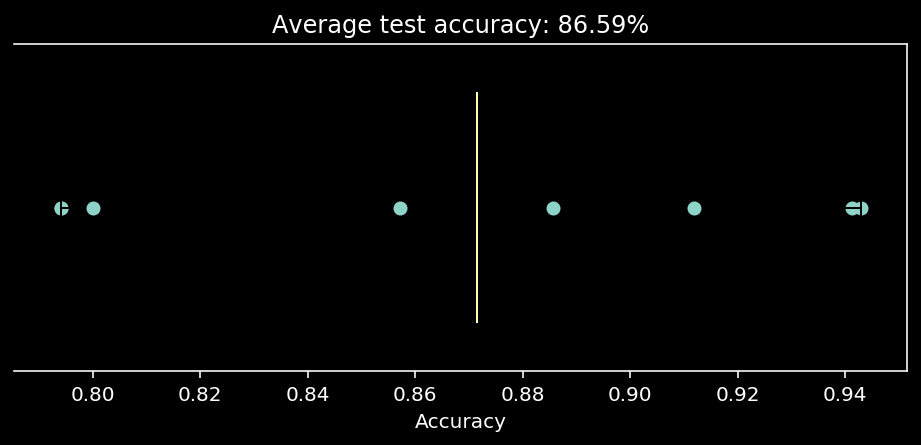

In [9]:
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8) # k=8 crossvalidation

# plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

Well that's sobering... what does this mean wrt the 100% accuracy we obtained before?

How can we overcome over-fitting?

### Regularization
Regularization is a central concept in ML. 
* it forces a model to learn a set solutions you a priori believe to be more correct
* reduces overfitting (less flexibility to fit idiosyncracies in the training data)
* adds model bias, but it's a good bias: typically it shrinks weights

The 2 main types of regularization are:
* $L_2$ regularization (aka "ridge" penalty): typically produces "dense" weights but of smaller values
$$\color{grey}{-\log\mathcal{L}'(\theta | X, y)=-\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i\theta_i^2}$$

* $L_1$ regularization (aka "Lasso" penalty): tpically produces "sparse" weights (with mostly zero values)
$$\color{grey}{-\log\mathcal{L}'(\theta | X, y)=-\log\mathcal{L}(\theta | X, y) +\frac\beta2\sum_i|\theta_i|}$$

Let's have a look...

Note: regularization hyperparameter $\color{grey}{ C = \frac{1}{\beta}}$

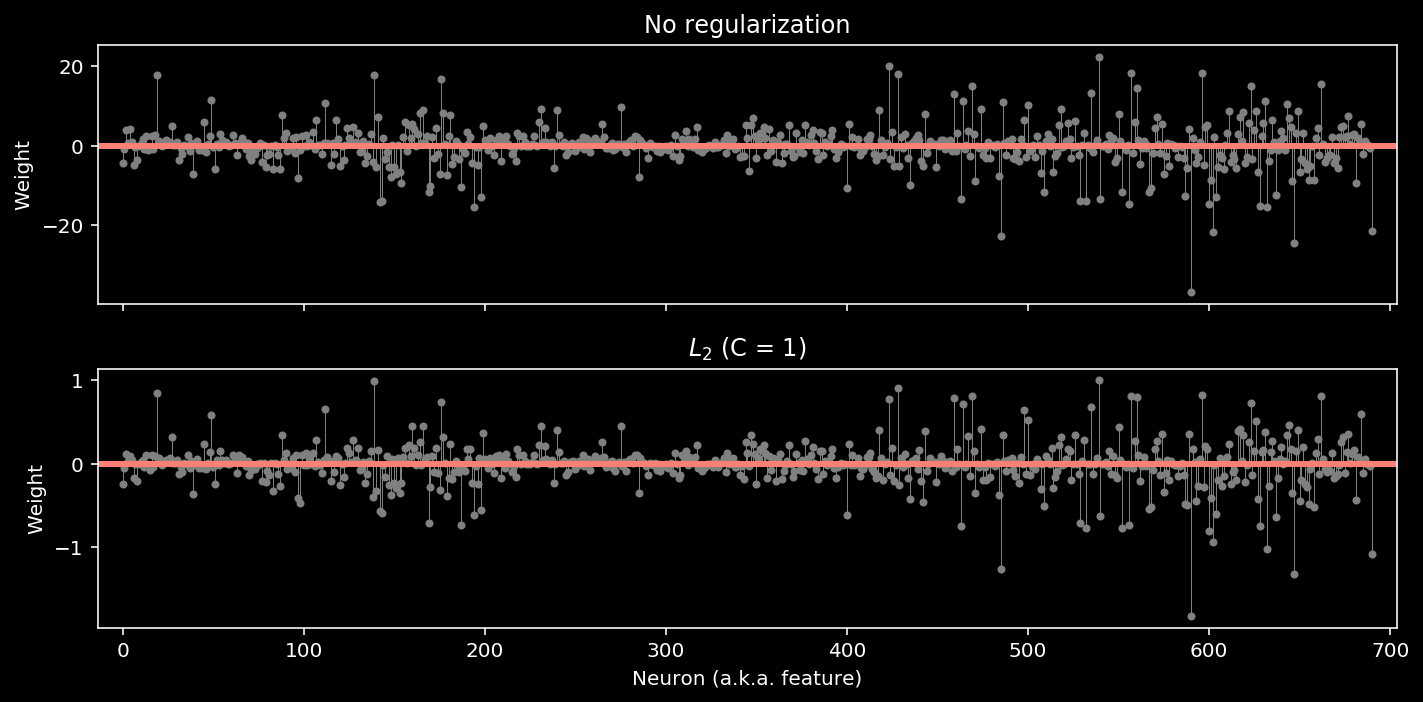

In [10]:
log_reg_l2 = LogisticRegression(penalty="l2", C=1).fit(X, y)

# now show the two models
models = {
  "No regularization": log_reg,
  "$L_2$ (C = 1)": log_reg_l2,
}
plot_weights(models, sharey=False)

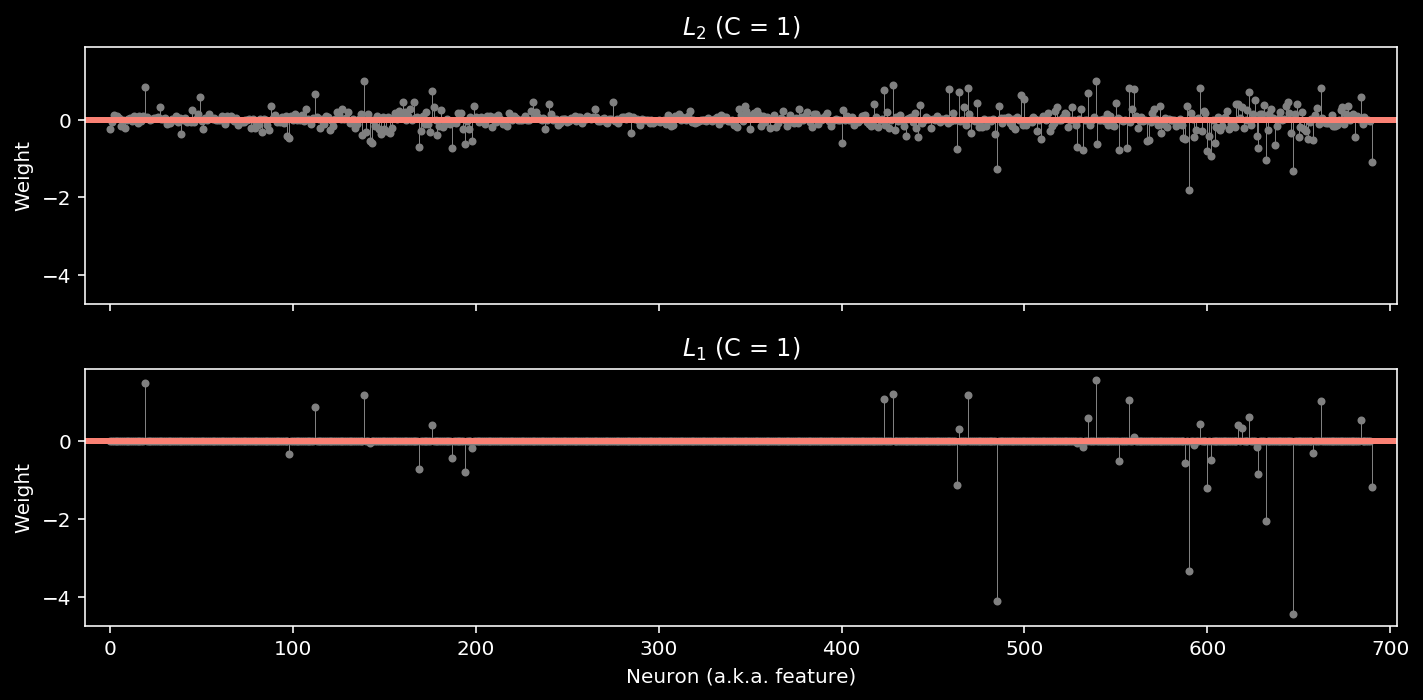

In [11]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
models = {
  "$L_2$ (C = 1)": log_reg_l2,
  "$L_1$ (C = 1)": log_reg_l1,
}
plot_weights(models)

Note: we added two additional parameters: solver="saga" and max_iter=5000. The LogisticRegression class can use several different optimization algorithms ("solvers"), and not all of them support the L1 penalty. At a certain point, the solver will give up if it hasn't found a minimum value. The max_iter parameter tells it to make more attempts; otherwise, we'd see an ugly warning about "convergence".

#### So how do we chose the best hyperparameter?
We'll look at the cross-validated classification accuracy...

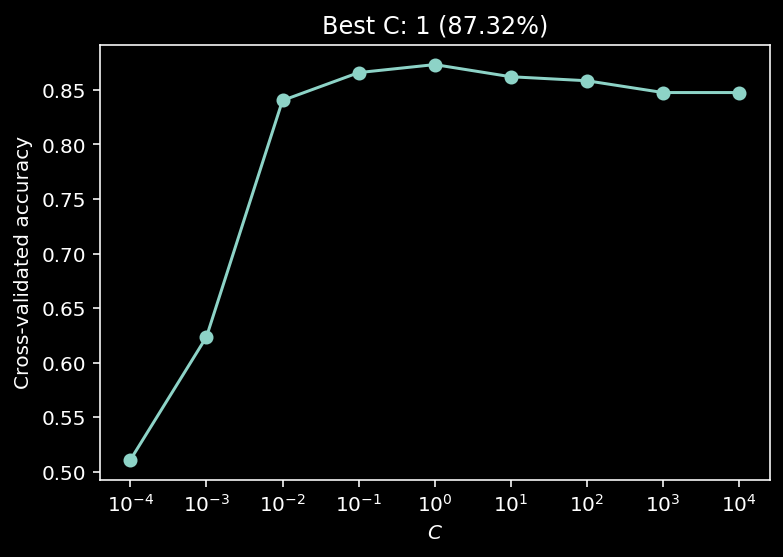

In [12]:
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values.
  Returns:
    accuracies (1D array): CV accuracy with each value of C.
  """
  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

    # Get the accuracy for each test split
    accs = cross_val_score(model, X, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

accuracies = model_selection(X, y, C_values)
plot_model_selection(C_values, accuracies)

### Dimensionality reduction
(adapted from [Neuromatch Academy W1D5 Tutorial 3](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D5_DimensionalityReduction/student/W1D5_Tutorial3.ipynb))

There are many forms of dimensionality reduction. The idea is that data is NOT uniformly distributed and thus there are some meaningful dimensions of data variability. Dimensionality reduction techniques focus on capturing the dominant dimensions of data variability.

We'll specifically be learning about **[Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)**, a linear method producing orthogonal axes.

<img style="float: center; width:750px;" src="stuff/PCA3d.png">

###  Let's perform of PCA on MNIST
[MNIST](https://en.wikipedia.org/wiki/MNIST_database) is a dataset of 70,000 images of handwritten digits. 

Each image is a 28x28 pixel grayscale image. For convenience, each 28x28 pixel image is often unravelled into a single 784 (=28*28) element vector, so that the whole dataset is represented as a 70,000 x 784 matrix. Each row represents a different image, and each column represents a different pixel.

Let's have a look...

In [21]:
# Helper Functions


def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained)
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()


def plot_MNIST_reconstruction(X, X_reconstructed):
  """
  Plots 9 images in the MNIST dataset side-by-side with the reconstructed
  images.

  Args:
    X (numpy array of floats)               : Data matrix each column
                                              corresponds to a different
                                              random variable
    X_reconstructed (numpy array of floats) : Data matrix each column
                                              corresponds to a different
                                              random variable

  Returns:
    Nothing.
  """

  plt.figure()
  ax = plt.subplot(121)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.title('Data')
  plt.clim([0, 250])
  ax = plt.subplot(122)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(np.real(X_reconstructed[k, :]), (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.clim([0, 250])
  plt.title('Reconstructed')
  plt.tight_layout()


def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """

  fig, ax = plt.subplots()
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 250])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_MNIST_weights(weights):
  """
  Visualize PCA basis vector weights for MNIST. Red = positive weights,
  blue = negative weights, white = zero weight.

  Args:
     weights (numpy array of floats) : PCA basis vector

  Returns:
     Nothing.
  """

  fig, ax = plt.subplots()
  cmap = plt.cm.get_cmap('seismic')
  plt.imshow(np.real(np.reshape(weights, (28, 28))), cmap=cmap)
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim(-.15, .15)
  plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def add_noise(X, frac_noisy_pixels):
  """
  Randomly corrupts a fraction of the pixels by setting them to random values.

  Args:
     X (numpy array of floats)  : Data matrix
     frac_noisy_pixels (scalar) : Fraction of noisy pixels

  Returns:
     (numpy array of floats)    : Data matrix + noise

  """

  X_noisy = np.reshape(X, (X.shape[0] * X.shape[1]))
  N_noise_ixs = int(X_noisy.shape[0] * frac_noisy_pixels)
  noise_ixs = np.random.choice(X_noisy.shape[0], size=N_noise_ixs,
                               replace=False)
  X_noisy[noise_ixs] = np.random.uniform(0, 255, noise_ixs.shape)
  X_noisy = np.reshape(X_noisy, (X.shape[0], X.shape[1]))

  return X_noisy


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def plot_eigenvalues(evals, limit=True):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals)
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()

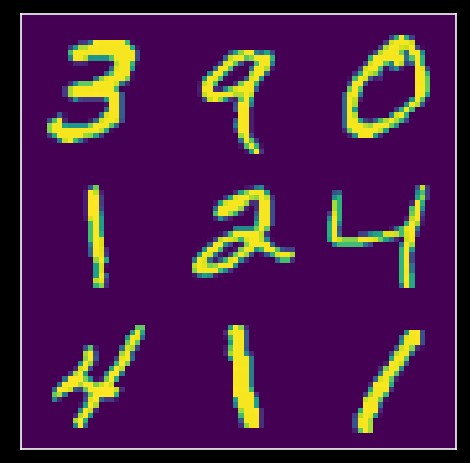

In [14]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name='mnist_784')
X = mnist.data
plot_MNIST_sample(X)

<img style="float: right; width:250px;" src="stuff/scree.jpg">
So the MNIST dataset has an extrinsic dimensionality of 784. To make sense of this data, we'll use dimensionality reduction. But first, we need to determine the intrinsic dimensionality K of the data. One way to do this is to look for an "elbow" in the scree plot, to determine which eigenvalues are signficant.

("Scree": collection of broken rock fragments at the base of mountain cliffs)

A scree plot is a line plot of the eigenvalues (= amplitude of variability) of factors or principal components in an analysis.

In [22]:
def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Vector of eigenvalues
    (numpy array of floats)    : Corresponding matrix of eigenvectors

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals


(0, 100)

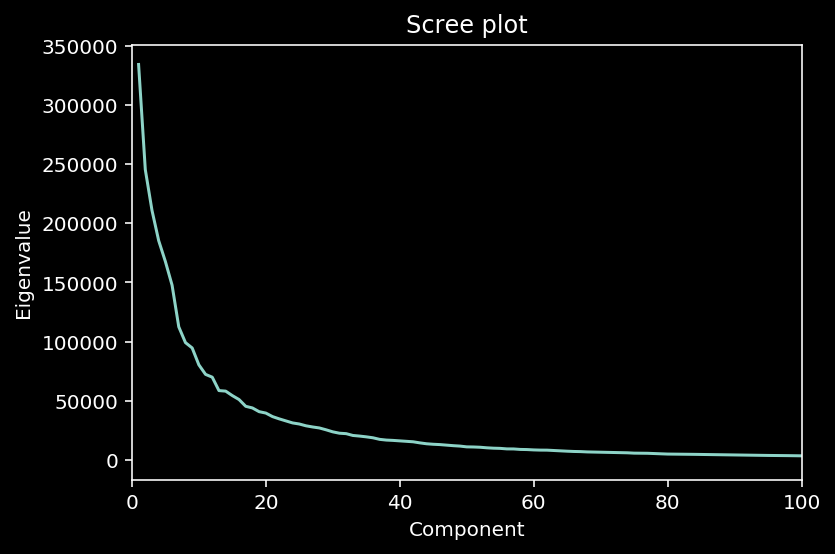

In [23]:
# perform PCA
score, evectors, evals = pca(X)

# plot the eigenvalues
plot_eigenvalues(evals, limit=False)
plt.xlim([0, 100])  # limit x-axis up to 100 for zooming

#### Variance explained
Note that in the scree plot most values are close to 0. So we can look at the intrinsic dimensionality of the data by analyzing the variance explained. 

This can be examined with a cumulative plot of the fraction of the total variance explained by the top $K$ components, i.e.,
$$\color{grey}{\text{var explained} = \frac{\sum_{i=1}^K \lambda_i}{\sum_{i=1}^N \lambda_i}}$$

The intrinsic dimensionality is often quantified by the $K$ necessary to explain a large proportion of the total variance of the data (often a defined threshold, e.g., 90%).

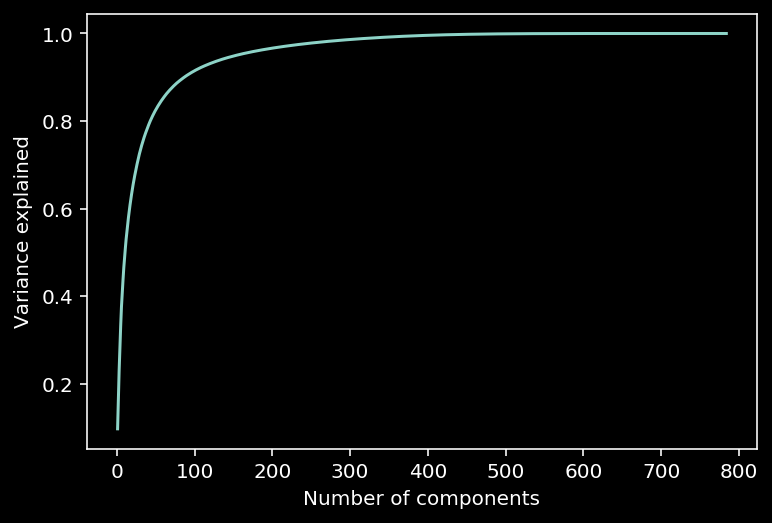

In [24]:
def get_variance_explained(evals):
  """
  Plots eigenvalues.
  Args:
    (numpy array of floats) : Vector of eigenvalues
  Returns:
    Nothing.
  """

  # cumulatively sum the eigenvalues
  csum = np.cumsum(evals)
  # normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained


# calculate the variance explained
variance_explained = get_variance_explained(evals)
plot_variance_explained(variance_explained)

#### Data reconstruction
Now we have seen that the top 100 or so principal components of the data can explain most of the variance. We can use this fact to perform dimensionality reduction, i.e., by storing the data using only 100 components rather than the samples of all 784 pixels. Remarkably, we will be able to reconstruct much of the structure of the data using only the top 100 components. 

Idea: only use the meaningful dimensions to recreate the data...

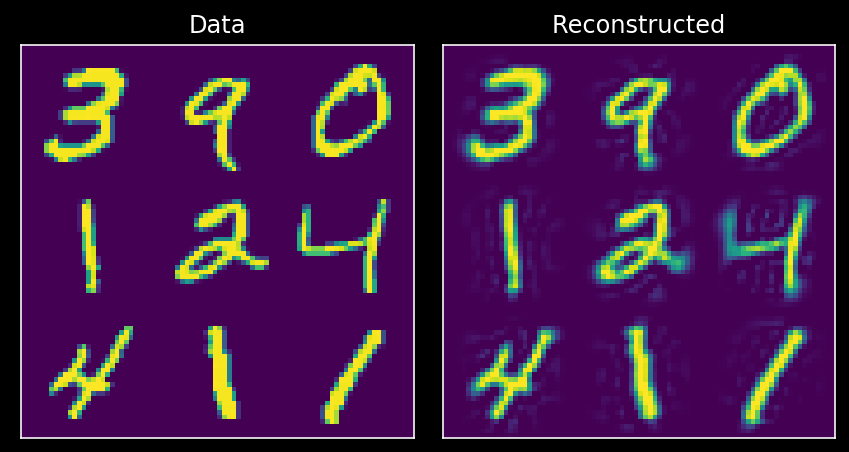

In [62]:
def reconstruct_data(score, evectors, X_mean, K):
  """
  Reconstruct the data based on the top K components.
  Args:
    score (numpy array of floats)    : Score matrix
    evectors (numpy array of floats) : Matrix of eigenvectors
    X_mean (numpy array of floats)   : Vector corresponding to data mean
    K (scalar)                       : Number of components to include
  Returns:
    (numpy array of floats)          : Matrix of reconstructed data
  """

  # Reconstruct the data from the score and eigenvectors
  # Don't forget to add the mean!!
  X_reconstructed =  np.matmul(score[:, :K], evectors[:, :K].T) + X_mean

  return X_reconstructed

K = 100

# Reconstruct the data based on all components
X_mean = np.mean(X, 0)
X_reconstructed = reconstruct_data(score, evectors, X_mean, K)

# Plot the data and reconstruction
plot_MNIST_reconstruction(X, X_reconstructed)

#### Visualization of weights
One of the cool things we can do now is examine the PCA weights!

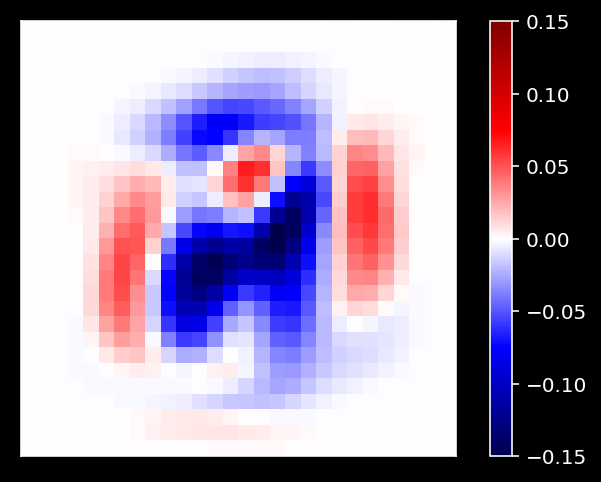

In [67]:
# Plot the weights of the first principal component
plot_MNIST_weights(evectors[:, 4])

#### Denoising with PCA
Noise is not meaningful variability. I.e., noise will not have a strong Eigenvalue. We can thus use PCA to denoise noisy data!

So let's do this: add noise to data first:

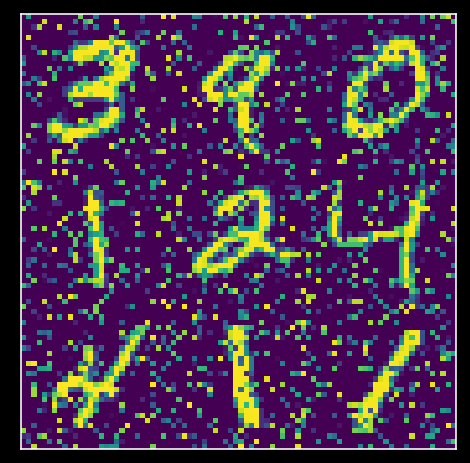

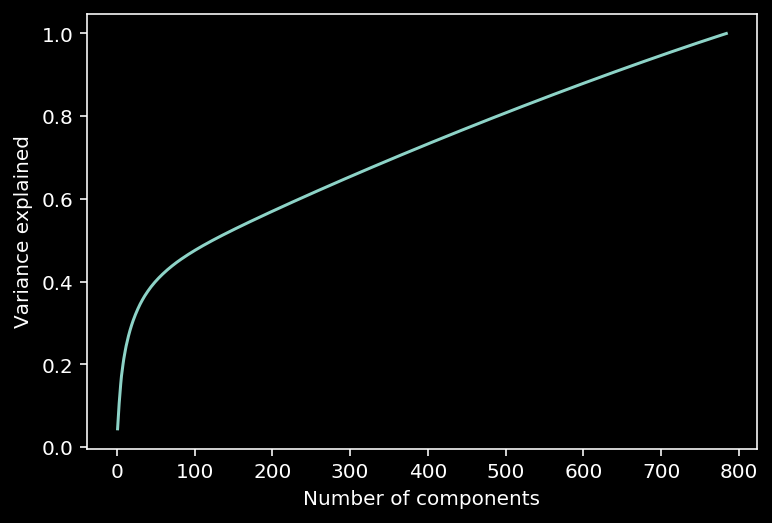

In [38]:
np.random.seed(2020)  # set random seed
X_noisy = add_noise(X, .2)
score_noisy, evectors_noisy, evals_noisy = pca(X_noisy)
variance_explained_noisy = get_variance_explained(evals_noisy)

plot_MNIST_sample(X_noisy)
plot_variance_explained(variance_explained_noisy)

Now we can use PCA to denoise our data by only retaining the top $K$ principal components that are meaningful. To do so, we'll project data onto the principal components found in the original dataset.

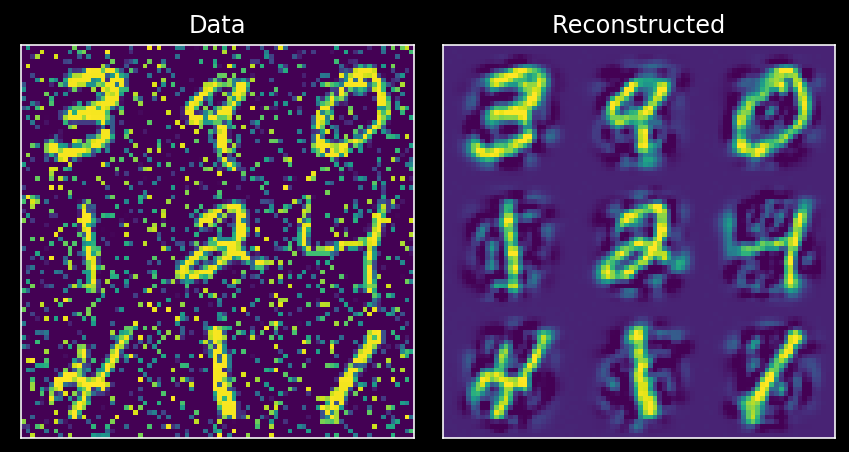

In [68]:
X_noisy_mean = np.mean(X_noisy, 0)
projX_noisy = np.matmul(X_noisy - X_noisy_mean, evectors)
X_reconstructed = reconstruct_data(projX_noisy, evectors, X_noisy_mean, 100) # use first 50 PCs

plot_MNIST_reconstruction(X_noisy, X_reconstructed)

### Decoding
(adapted from [Neuromatch Academy W3D4 Tutorial 1](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D4_DeepLearning1/student/W3D4_Tutorial1.ipynb))

**Typical question in neuroscience**: how much information does brain area X have about external correlate Y?

We'll use the [Stringer et al. (2019)](https://www.biorxiv.org/content/10.1101/679324v2.abstract) dataset of ~20,000 simultaneously recorded neurons from mouse V1. 

**Goal**: decode the orientation of the stimulus from the population

(the mouse made a decision on stimulus orientation)

**Approach**: use deep learning (DL) because
* DL thrives with high-dimensional data
* DL is great with nonlinear patterns: neurons respond quite differently
* DL architectures are very flexible - you can adapt it to maximize decoding

We'll use [`pytorch`](https://pytorch.org/) for decoding...

But before getting started, let's load and look at the data!

In [43]:
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

In [44]:
# Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [45]:
# Helper Functions

def load_data(data_name=fname, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontanous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def plot_data_matrix(X, ax):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot

  """

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1), vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])


def identityLine():
  """
  Plot the identity line y=x
  """
  ax = plt.gca()
  lims = np.array([ax.get_xlim(), ax.get_ylim()])
  minval = lims[:, 0].min()
  maxval = lims[:, 1].max()
  equal_lims = [minval, maxval]
  ax.set_xlim(equal_lims)
  ax.set_ylim(equal_lims)
  line = ax.plot([minval, maxval], [minval, maxval], color="0.7")
  line[0].set_zorder(-1)

def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

def stimulus_class(ori, n_classes):
  """Get stimulus class from stimulus orientation

  Args:
    ori (torch.Tensor): orientations of stimuli to return classes for
    n_classes (int): total number of classes

  Returns:
    torch.Tensor: 1D tensor with the classes for each stimulus

  """
  bins = np.linspace(0, 360, n_classes + 1)
  return torch.tensor(np.digitize(ori.squeeze(), bins)) - 1  # minus 1 to accomodate Python indexing

def plot_decoded_results(train_loss, test_labels, predicted_test_labels):
  """ Plot decoding results in the form of network training loss and test predictions

  Args:
    train_loss (list): training error over iterations
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  # Plot results
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  # Plot the training loss over iterations of GD
  ax1.plot(train_loss)

  # Plot true stimulus orientation vs. predicted class
  ax2.plot(stimuli_test.squeeze(), predicted_test_labels, '.')

  ax1.set_xlim([0, None])
  ax1.set_ylim([0, None])
  ax1.set_xlabel('iterations of gradient descent')
  ax1.set_ylabel('negative log likelihood')
  ax2.set_xlabel('true stimulus orientation ($^o$)')
  ax2.set_ylabel('decoded orientation bin')
  ax2.set_xticks(np.linspace(0, 360, n_classes + 1))
  ax2.set_yticks(np.arange(n_classes))
  class_bins = [f'{i * 360 / n_classes: .0f}$^o$ - {(i + 1) * 360 / n_classes: .0f}$^o$' for i in range(n_classes)]
  ax2.set_yticklabels(class_bins);

  # Draw bin edges as vertical lines
  ax2.set_ylim(ax2.get_ylim())  # fix y-axis limits
  for i in range(n_classes):
    lower = i * 360 / n_classes
    upper = (i + 1) * 360 / n_classes
    ax2.plot([lower, lower], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)
    ax2.plot([upper, upper], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)

  plt.tight_layout()

23589 neurons in response to 360 stimuli


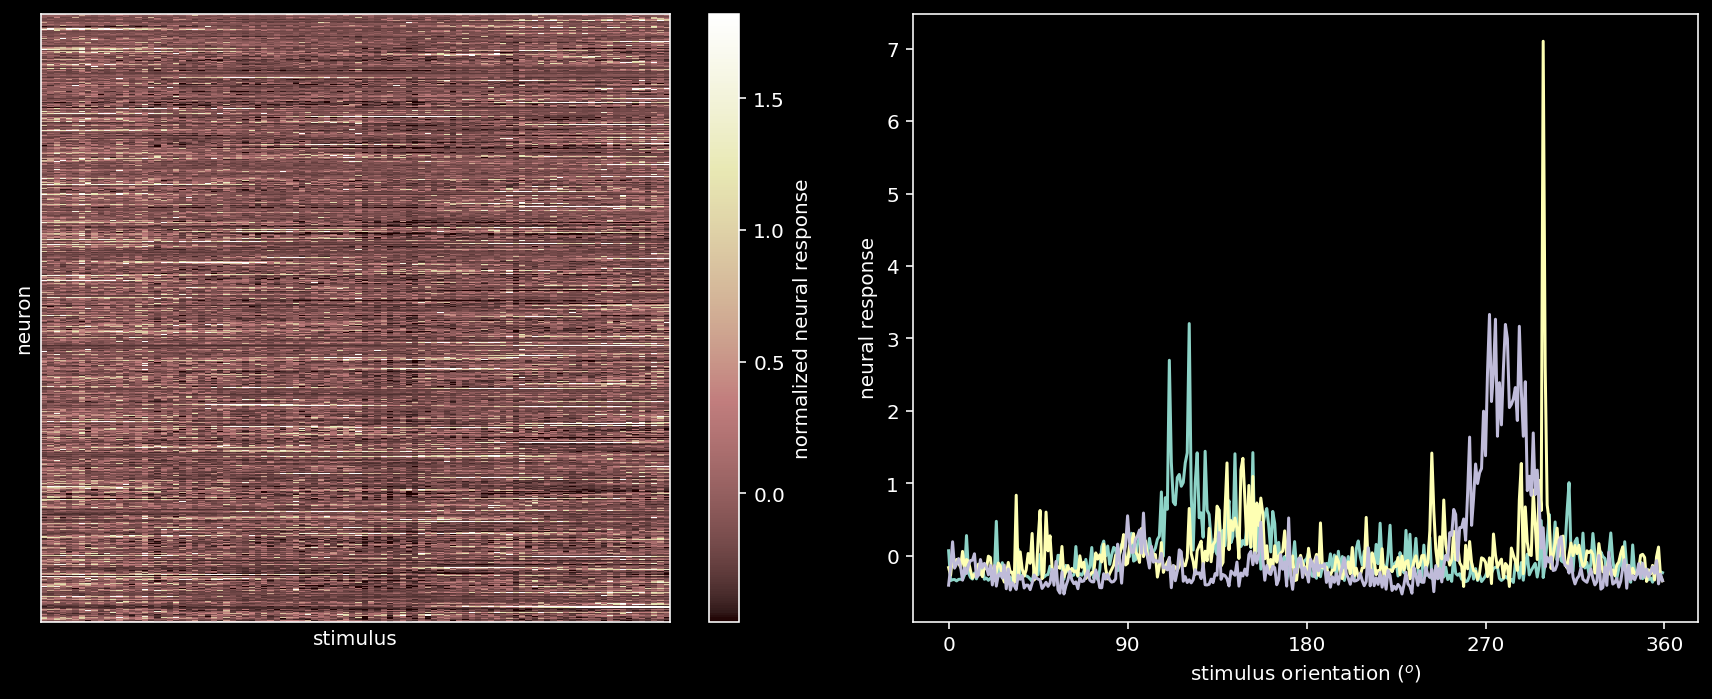

In [46]:
# Load data
resp_all, stimuli_all = load_data()  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

print(f'{n_neurons} neurons in response to {n_stimuli} stimuli')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
plot_data_matrix(resp_all[:100, :].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

plt.tight_layout()

Now let's split our dataset into *training set* and *test set*. 

In [47]:
# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_all[itest]
resp_test = resp_all[itest]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]

#### Deep feed-forward networks in pytorch
We will build a very simple 3-layer network, aka a universal function approximator.

<img style="float: center; width:500px;" src="stuff/one-layer-network.png">


In [48]:
class DeepNet(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    """Decode stimulus orientation from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
        containing n_stimuli vectors of neural responses

    Returns:
      torch.Tensor: network outputs for each input provided in r. If
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape n_stimuli x 1.

    """
    h = self.in_layer(r)  # hidden representation
    y = self.out_layer(h)
    return y

Let's see if this works?

In [49]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
net = DeepNet(n_neurons, 200)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
out = net(r)  # compute output from network, equivalent to net.forward(r)

print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.08 degrees
true orientation: 139.00 degrees


It works, but the output is nonsense because we have not trained the network yet!

#### Activation functions
Our network has purely linear layers so far, i.e. sum of weighted inputs. But to be come a universal function approximator, we need nonlinear activation functions, e.g.
* sigmoid
* ReLU (Rectivied Linear Units) - we'll be using this here

<img style="float: center; width:500px;" src="stuff/ReLU.png">

In [50]:
class DeepNetReLU(nn.Module):

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):

    h = torch.relu(self.in_layer(r))
    y = self.out_layer(h)

    return y


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)


# Initialize deep network with M=20 hidden units and uncomment lines below
net = DeepNetReLU(n_neurons, 20)

# Decode orientation from these neural responses using initialized network
# net(r) is equivalent to net.forward(r)
out = net(r)

print('decoded orientation: %.2f degrees' % out)
print('true orientation: %.2f degrees' % ori)

decoded orientation: 0.13 degrees
true orientation: 139.00 degrees


This is of course still nonsense. So let's look at training the network decoder...

#### Loss function and gradient descent
In the same way that we had a loss function (cost function) for model fitting, we need one for our neural network model too. We'll simply be using the mean squared error (MSE) again. 
$$\color{grey}{L = \frac{1}{P}\sum_{n=1}^P \left(y^{(n)} - \tilde{y}^{(n)}\right)^2}$$
Let's evaluate the loss for our (untrained network)...

In [51]:

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=20 hidden units
net = DeepNetReLU(n_neurons, 20)

# Get neural responses to first 20 stimuli in the data set
r, ori = get_data(20, resp_train, stimuli_train)

# Decode orientation from these neural responses
out = net(r)

# Initialize PyTorch mean squared error loss function (Hint: look at nn.MSELoss)
loss_fn = nn.MSELoss()

# Evaluate mean squared error
loss = loss_fn(out, ori)

print('mean squared error: %.2f' % loss)

mean squared error: 42943.75


We can now do gradient descent. 
<img style="float: center; width:500px;" src="stuff/ball.png">

iteration 40/200 | loss: 285.460
iteration 80/200 | loss: 58.562
iteration 120/200 | loss: 16.741
iteration 160/200 | loss: 6.620
iteration 200/200 | loss: 3.193


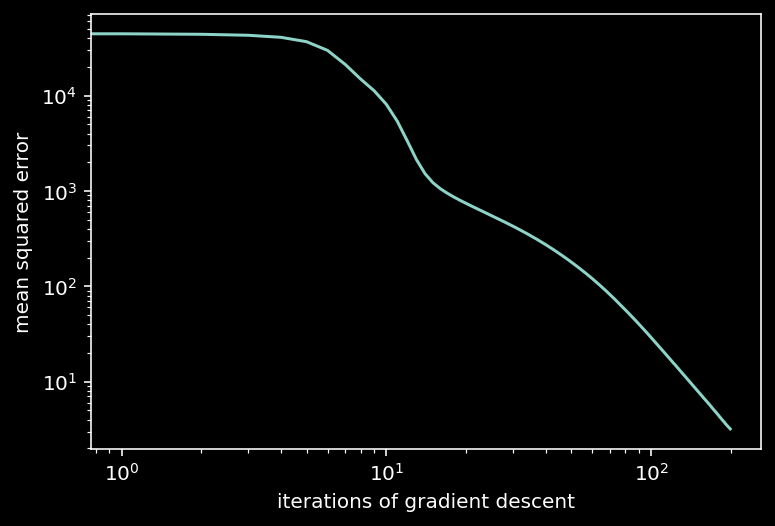

In [69]:
def train(net, loss_fn, train_data, train_labels, n_iter=200, learning_rate=1e-4):
  """Run gradient descent to opimize parameters of a given network
  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    n_iter (int): number of iterations of gradient descent to run
    learning_rate (float): learning rate to use for gradient descent
  """

  # Initialize PyTorch Stochastic Gradient Descent (SGD) optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  track_loss = []

  # Loop over epochs (cf. appendix)
  for i in range(n_iter):

    # Evaluate loss using loss_fn
    out = net(train_data)  # compute network output from inputs in train_data
    loss = loss_fn(out, train_labels)  # evaluate loss function

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    track_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_iter // 5) == 0:
      print(f'iteration {i + 1}/{n_iter} | loss: {loss.item():.3f}')

  return track_loss

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network
net = DeepNetReLU(n_neurons, 20)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run GD on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plt.loglog(train_loss)
plt.xlabel('iterations of gradient descent')
plt.ylabel('mean squared error')
plt.show()

#### Evaluate model performance
Using the testset, we can now plot the model's prediction (decoded orientation) over the true orientation.

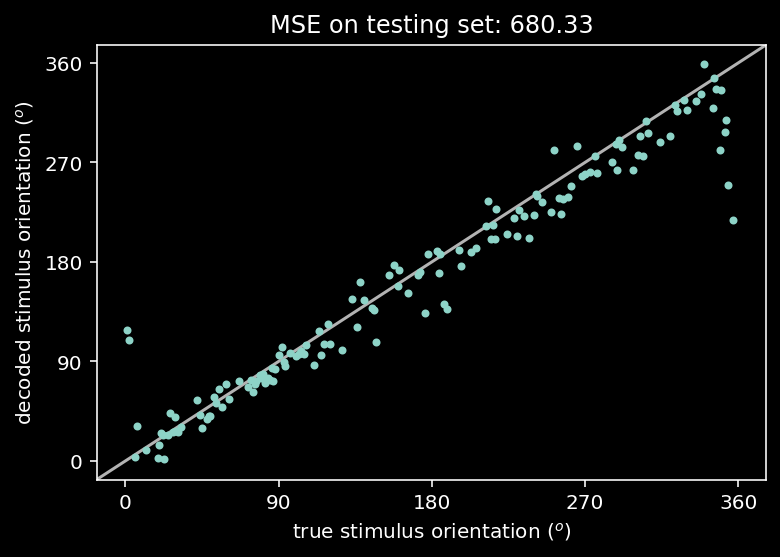

In [70]:
# evaluate and plot test error

out = net(resp_test)  # decode stimulus orientation for neural responses in testing set
ori = stimuli_test  # true stimulus orientations
test_loss = loss_fn(out, ori)  # MSE on testing set (Hint: use loss_fn initialized in previous exercise)

plt.plot(ori, out.detach(), '.')  # N.B. need to use .detach() to pass network output into plt.plot()
identityLine()  # draw the identity line y=x; deviations from this indicate bad decoding!
plt.title('MSE on testing set: %.2f' % test_loss.item())  # N.B. need to use .item() to turn test_loss into a scalar
plt.xlabel('true stimulus orientation ($^o$)')
plt.ylabel('decoded stimulus orientation ($^o$)')
axticks = np.linspace(0, 360, 5)
plt.xticks(axticks)
plt.yticks(axticks)
plt.show()

### Further readings
* [Bishop's pattern recognition and ML book](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)
* [Zhang et al. book with Python tutorials](http://d2l.ai/)
* [Goodfellow, Belgio and Courville book](http://www.deeplearningbook.org/)
* [check out W1D4-5 and W3D4-5 of NMA](https://github.com/NeuromatchAcademy/course-content)
* Summer 2021 there will be a deep learning NMA!!!